In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
from data_reader import read_data
from node import get_node_data
import pandas as pd
import numpy as np

In [3]:
data = read_data()
# nodes = {"pi"+str(i+2):i for i in range(4)}

## Visualising Data

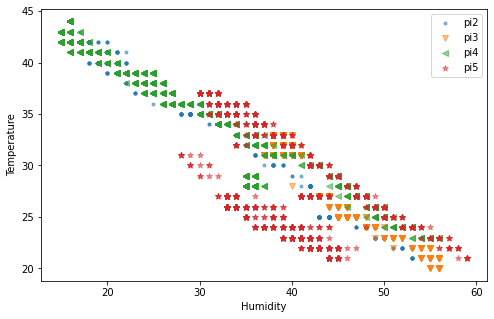

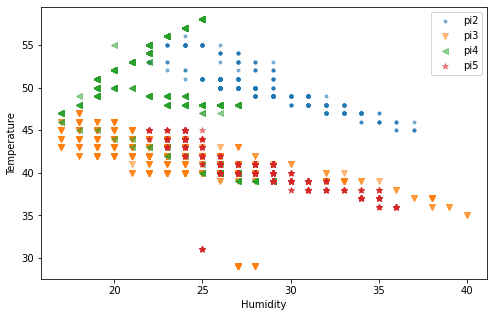

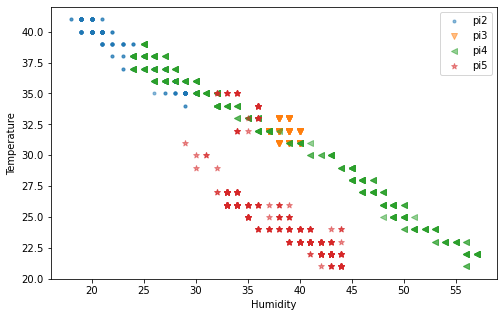

In [4]:
from visualising import visualise_experiments
visualise_experiments(data)

## Similarity MMD

In [16]:
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable

def bandwidth_experiment(samples, similar_sets, dissimilar_sets, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASDMMD(samples, similar_sets, dissimilar_sets, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

### Experiment 1

Nodes pi2 and pi4 are similar according to mmd and nodes pi3 and pi5 are similar to each other but not to the others

In [26]:
from maximum_mean_discrepancy import get_tensor_samples
m = 200
samples = get_tensor_samples(data, experiment=1, sample_size=m)

In [6]:
similar_sets = ["pi2","pi4"]
dissimilar_sets = ["pi3","pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi2', 'pi4') | tensor(2.0339) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi3', 'pi2') | tensor(32.9921) |
| ('pi3', 'pi4') | tensor(32.4272) |
| ('pi5', 'pi2') | tensor(27.7680) |
| ('pi5', 'pi4') | tensor(27.0771) |
| ('pi3', 'pi5') |  tensor(3.7611) |
+----------------+-----------------+

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi2', 'pi4') | tensor(6.1016) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi3', 'pi2') | tensor(98.9763) |
| ('pi3', 'pi4') | tensor(97.2816) |
| ('pi5', 'pi2') | tensor(83.3041) |
| ('pi5', 'pi4') | tensor(81.2314) |
| ('pi3', 'pi5') | tensor(11.2832) |
+

similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

### Experiment 3

Nodes pi3, pi4, pi5 are dissimilar with pi2. Nodes pi3 and pi4 are similar to each other and similar to pi5.

In [35]:
samples = get_tensor_samples(data, experiment=3, sample_size=m)

In [36]:
similar_sets = ["pi2", "pi4"]
dissimilar_sets = ["pi3", "pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi4') | tensor(30.2673) |
| ('pi3', 'pi2') | tensor(28.2074) |
| ('pi3', 'pi4') |  tensor(2.6067) |
| ('pi5', 'pi4') |  tensor(5.7325) |
| ('pi3', 'pi5') |  tensor(7.0070) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi5', 'pi2') | tensor(39.8775) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi4') | tensor(90.8019) |
| ('pi3', 'pi2') | tensor(84.6223) |
| ('pi3', 'pi4') |  tensor(7.8203) |
| ('pi5', 'pi4') | tensor(17.1976) |
| ('pi3', 'pi5') | tensor(21.0213) |
+----------------+-----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi5', 'pi2') | tensor

similar_sets = ["pi2", "pi3", "pi4"]
dissimilar_sets = ["pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

### Experiment 2

In [45]:
samples = get_tensor_samples(data, experiment=2, sample_size=m)

In [46]:
similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(5,100 , 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi5') | tensor(5.3385) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(12.1883) |
| ('pi2', 'pi5') | tensor(12.5109) |
| ('pi4', 'pi3') | tensor(12.6573) |
| ('pi4', 'pi5') | tensor(18.7198) |
| ('pi2', 'pi4') |  tensor(6.0502) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi3', 'pi5') | tensor(16.0155) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(36.5647) |
| ('pi2', 'pi5') | tensor(37.5326) |
| ('pi4', 'pi3') | tensor(37.9719) |
| ('pi4', 'pi5') | tensor(56.1593) |
| ('pi2', 'pi4') | tensor(18.1506

## Testing Hypothesis

In [21]:
from sklearn.preprocessing import StandardScaler
# from maximum_mean_discrepancy import get_sample_indices
from visualising import visualise_train_test_data

def get_xy_data(data):
    x = data.humidity.values.astype(np.float32)
    y = data.temperature.values.astype(np.float32)
    return x, y

def get_model_data(experiment, standardised = False, original=True, plot=False):
    model_data = {}
    node_data = get_node_data(data, experiment)
    
    if standardised:
        scaler = StandardScaler()
        scaler.fit(pd.concat(node_data))
    
    if plot:
        plot_data = []
    
    for i in range(4):
        node = "pi"+str(i+2)
        train = node_data[i].sample(frac=0.8)
        test = node_data[i].iloc[~node_data[i].index.isin(train.index)] 
        model_data[node] = [get_xy_data(train), get_xy_data(test)] 
        if standardised:
            std_train = scaler.transform(train)
            std_test =  scaler.transform(test)
            model_data[node].append((std_train[:,0],std_train[:,1]))
            model_data[node].append((std_test[:,0],std_test[:,1]))
        if plot:
            plot_data.append([train, test])
    if plot:
        visualise_train_test_data(plot_data)
        
    return model_data

In [8]:
from modelling import fit_clf, score_clf
from prettytable import PrettyTable

def test_in_pairs(similar_sets, model_data, models):
    t = PrettyTable(['Model Node', 'Test Node', 'Model Node R', 'Test Node R'])
    for pair in similar_sets:
        x, x_test = model_data[pair[0]]
        y, y_test = model_data[pair[1]]
        model_x, model_y = models[pair[0]], models[pair[1]]

        baseline_score = fit_clf(model_x, x, x_test)
        test_score = score_clf(model_x, y_test)
        t.add_row([pair[0], pair[1], baseline_score, test_score])

        baseline_score = fit_clf(model_y, y, y_test)
        test_score = score_clf(model_y, x_test)        
        t.add_row([pair[1], pair[0], baseline_score, test_score])
    print(t)

In [9]:
from maximum_mean_discrepancy import get_tensor_samples, find_similar_pairs
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable
from node import get_similar_other_nodes_sets
from modelling import grid_search_models

def select_model_data(experiment, kernel, kernel_bandwidth, standardised, original):
    similar_nodes, other_nodes = get_similar_other_nodes_sets(experiment)
    model_data = get_model_data(experiment, standardised, original)
    data_samples = get_tensor_samples(data, experiment, sample_size=200, standardised = False)
    
    asmmd = ASDMMD(data_samples, similar_nodes, other_nodes, kernel, kernel_bandwidth, return_tables = False)
    similar_pairs, similar_nodes = find_similar_pairs({node:model_data[node][:2] for node in model_data.keys()}, 
                                                      asmmd, kernel, kernel_bandwidth)
    
    selected_model_data = {node : model_data[node] for node in similar_nodes}
    
    print(f"The average MMD between similar sets is {asmmd}")
    print(f"The following pairs of nodes were deemed similar {similar_pairs} \n")
    
    return selected_model_data, similar_pairs, similar_nodes

def test_hypothesis(clf_name, model_data, similar_pairs, similar_nodes): 
    print("Optimising Models... \n")
    models = grid_search_models(clf_name, model_data, similar_nodes)
    test_in_pairs(similar_pairs, model_data, models)
    print()
    
def test_hypothesis_all_clfs(experiment, kernel, kernel_bandwidth):
    model_data, similar_pairs, similar_nodes = select_model_data(experiment, kernel, kernel_bandwidth, 
                                                                 standardised=True, original=True)
    
    normal_data = {node:model_data[node][:2] for node in model_data.keys()}
    std_data = {node:model_data[node][2:] for node in model_data.keys()}
    
    test_hypothesis("svr", normal_data, similar_pairs, similar_nodes)
#     test_hypothesis("lsvr", std_data, similar_pairs, similar_nodes)
    test_hypothesis("lreg", normal_data, similar_pairs, similar_nodes)

In [22]:
test_hypothesis_all_clfs(experiment = 2, kernel = "linear", kernel_bandwidth = 0.7)

The average MMD between similar sets is 32.627197265625
The following pairs of nodes were deemed similar [('pi2', 'pi4'), ('pi3', 'pi5')] 

Optimising Models... 

+------+----------------+--------------------+-------------------------+---------------------+
| Node | Baseline Model |     Baseline R     |     Optimised Model     |  Optimised Model R  |
+------+----------------+--------------------+-------------------------+---------------------+
| pi2  |     SVR()      | 0.7357018508871718 | SVR(C=100, epsilon=0.2) |  0.7306716941994755 |
| pi4  |     SVR()      | 0.4438730009241859 |   SVR(C=10, epsilon=1)  |  0.4882521963369545 |
| pi3  |     SVR()      | 0.4290482883608233 |  SVR(C=100, epsilon=1)  | 0.48150874713668035 |
| pi5  |     SVR()      | 0.5288417769380955 |  SVR(C=1, epsilon=0.2)  |  0.5485402999159329 |
+------+----------------+--------------------+-------------------------+---------------------+
+------------+-----------+---------------------+----------------------+
| Mod

In [23]:
test_hypothesis_all_clfs(experiment = 1, kernel = "linear", kernel_bandwidth = 0.5)

The average MMD between similar sets is 11.39306640625
The following pairs of nodes were deemed similar [('pi2', 'pi4'), ('pi3', 'pi5')] 

Optimising Models... 

+------+----------------+--------------------+-------------------------+--------------------+
| Node | Baseline Model |     Baseline R     |     Optimised Model     | Optimised Model R  |
+------+----------------+--------------------+-------------------------+--------------------+
| pi2  |     SVR()      | 0.9850011098206157 | SVR(C=100, epsilon=0.2) | 0.9886459729520083 |
| pi4  |     SVR()      | 0.9478839608554617 | SVR(C=100, epsilon=0.5) | 0.959254029262493  |
| pi3  |     SVR()      | 0.9778337592485936 | SVR(C=100, epsilon=0.2) | 0.9788252339329478 |
| pi5  |     SVR()      | 0.4547105787708611 |  SVR(C=100, epsilon=1)  | 0.4721946380769537 |
+------+----------------+--------------------+-------------------------+--------------------+
+------------+-----------+--------------------+----------------------+
| Model Node | 

In [24]:
test_hypothesis_all_clfs(experiment = 3, kernel = "linear", kernel_bandwidth = 0.5)

The average MMD between similar sets is 24.814208984375
The following pairs of nodes were deemed similar [('pi3', 'pi4'), ('pi4', 'pi5')] 

Optimising Models... 

+------+----------------+----------------------+-------------------------+-----------------------+
| Node | Baseline Model |      Baseline R      |     Optimised Model     |   Optimised Model R   |
+------+----------------+----------------------+-------------------------+-----------------------+
| pi3  |     SVR()      | 0.005608123769831219 | SVR(C=0.1, epsilon=0.2) | -8.96902427096613e-05 |
| pi4  |     SVR()      |  0.9872767910255115  | SVR(C=100, epsilon=0.2) |   0.9896281090510639  |
| pi5  |     SVR()      |  0.5959854486023994  |   SVR(C=10, epsilon=1)  |   0.6154728197652791  |
+------+----------------+----------------------+-------------------------+-----------------------+
+------------+-----------+----------------------+----------------------+
| Model Node | Test Node |     Model Node R     |     Test Node R      